# Heart Disease Prediction - Modeling

This notebook implements and compares various machine learning models:
- Naive Bayes
- K-Nearest Neighbors (KNN)
- Decision Tree
- Random Forest
- Gradient Boosting
- Ensemble Methods (Voting Classifier)


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
import warnings
from pathlib import Path
import sys

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

# Load data directly
df = pd.read_csv('../data/raw/Heart_disease_cleveland_new.csv')
print(f"Dataset loaded: {df.shape}")

# Quick data check
print(f"Columns: {list(df.columns)}")
print(f"Target unique values: {sorted(df['target'].unique()) if 'target' in df.columns else 'No target column'}")

# Define features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

available_numerical = [col for col in numerical_features if col in df.columns]
available_categorical = [col for col in categorical_features if col in df.columns]

print(f"Available numerical features: {available_numerical}")
print(f"Available categorical features: {available_categorical}")


Dataset loaded: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Target unique values: [np.int64(0), np.int64(1)]
Available numerical features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
Available categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


## 1. Data Preprocessing and Feature Engineering


In [7]:
# Data preprocessing
print("="*60)
print("============= Data Preprocessing ==============")
print("="*60)

if 'target' not in df.columns:
    print("❌ Target column not found! Cannot proceed with modeling.")
    print("Available columns:", list(df.columns))
else:
    # Simple preprocessing - just use available features
    feature_cols = available_numerical + available_categorical
    print(f"Using features: {feature_cols}")
    
    # Remove rows with missing values in target
    df_clean = df.dropna(subset=['target'])
    print(f"After removing target missing values: {df_clean.shape}")
    
    # Split data
    X = df_clean[feature_cols]
    y = df_clean['target']
    
    # Handle missing values in features
    X = X.fillna(X.median())  # Fill numerical with median
    print(f"After handling missing values: {X.shape}")
    
    # Split into train/val/test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
    
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print(f"Target distribution in train: {y_train.value_counts().to_dict()}")
    print(f"Target distribution in val: {y_val.value_counts().to_dict()}")
    print(f"Target distribution in test: {y_test.value_counts().to_dict()}")
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    if available_numerical:
        X_train_scaled[available_numerical] = scaler.fit_transform(X_train[available_numerical])
        X_val_scaled[available_numerical] = scaler.transform(X_val[available_numerical])
        X_test_scaled[available_numerical] = scaler.transform(X_test[available_numerical])
    
    print("✅ Data preprocessing completed successfully!")


============= Data Preprocessing ==============
Using features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
After removing target missing values: (303, 14)
After handling missing values: (303, 13)
Train: (181, 13), Val: (61, 13), Test: (61, 13)
Target distribution in train: {0: 98, 1: 83}
Target distribution in val: {0: 33, 1: 28}
Target distribution in test: {0: 33, 1: 28}
✅ Data preprocessing completed successfully!


## 2. Individual Model Training and Evaluation


In [8]:
# Train individual models
print("="*60)
print("========== Individual Model Training ==========")
print("="*60)

if 'target' not in df.columns:
    print("❌ Cannot train models - target column not found!")
else:
    # Define models with optimized parameters
    models = {
        'Naive Bayes': GaussianNB(var_smoothing=1e-9),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='distance'),
        'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    }

    # Train and evaluate each model
    model_results = {}
    validation_results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model on scaled data
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)
        y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        
        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        val_roc_auc = roc_auc_score(y_val, y_val_pred_proba) if y_val_pred_proba is not None else 0
        
        train_metrics = {'accuracy': train_acc, 'f1': train_f1}
        val_metrics = {'accuracy': val_acc, 'f1': val_f1, 'roc_auc': val_roc_auc}
        
        model_results[name] = {
            'model': model,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'predictions': y_val_pred,
            'probabilities': y_val_pred_proba
        }
        
        validation_results[name] = val_metrics
        
        print(f"Train - Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

    # Display results summary
    print("\n" + "="*60)
    print("VALIDATION RESULTS SUMMARY")
    print("="*60)
    results_df = pd.DataFrame(validation_results).T
    display(results_df.round(4))


========== Individual Model Training ==========

Training Naive Bayes...
Train - Accuracy: 0.8508, F1: 0.8344
Val   - Accuracy: 0.8525, F1: 0.8302, ROC-AUC: 0.9167

Training K-Nearest Neighbors...
Train - Accuracy: 1.0000, F1: 1.0000
Val   - Accuracy: 0.8361, F1: 0.8214, ROC-AUC: 0.9069

Training Decision Tree...
Train - Accuracy: 0.9779, F1: 0.9753
Val   - Accuracy: 0.7541, F1: 0.7273, ROC-AUC: 0.7424

Training Random Forest...
Train - Accuracy: 1.0000, F1: 1.0000
Val   - Accuracy: 0.8197, F1: 0.8000, ROC-AUC: 0.9042

Training Gradient Boosting...
Train - Accuracy: 0.9945, F1: 0.9939
Val   - Accuracy: 0.8361, F1: 0.8214, ROC-AUC: 0.8983

VALIDATION RESULTS SUMMARY


,accuracy,f1,roc_auc
Naive Bayes,0.8525,0.8302,0.9167
K-Nearest Neighbors,0.8361,0.8214,0.9069
Decision Tree,0.7541,0.7273,0.7424
Random Forest,0.8197,0.8000,0.9042
Gradient Boosting,0.8361,0.8214,0.8983


## 3. Model Performance Visualization


====== Model Performance Visualization ======


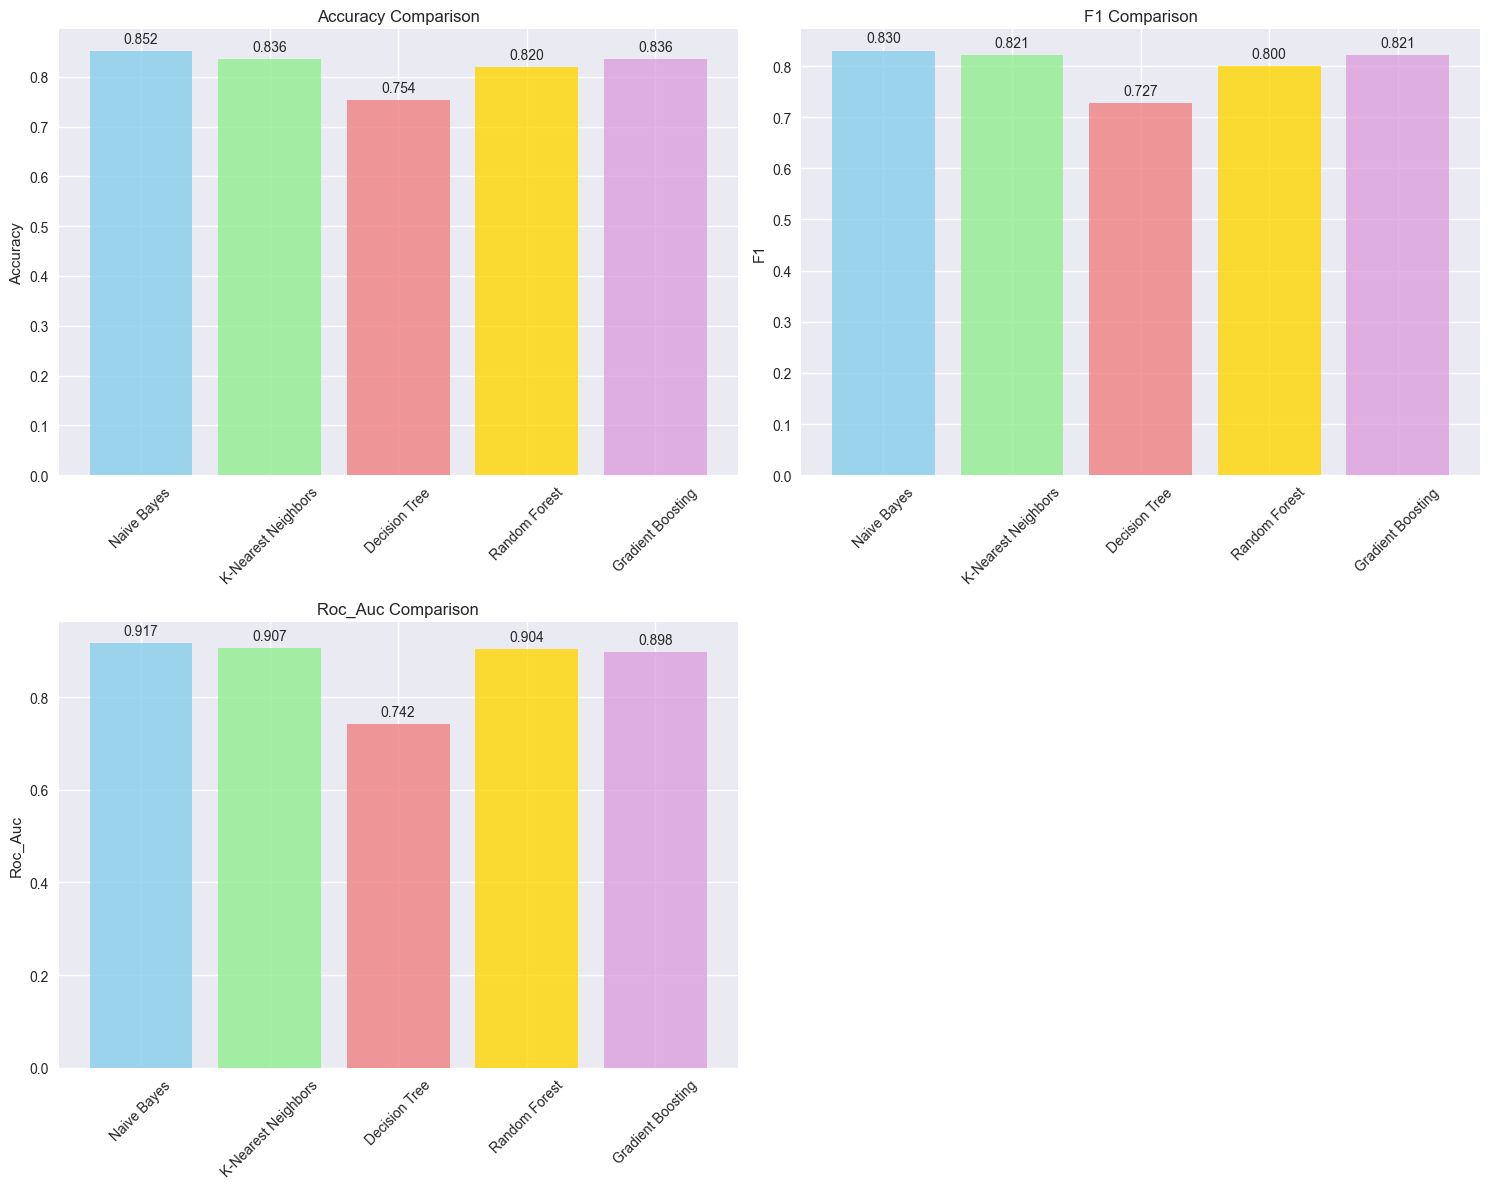

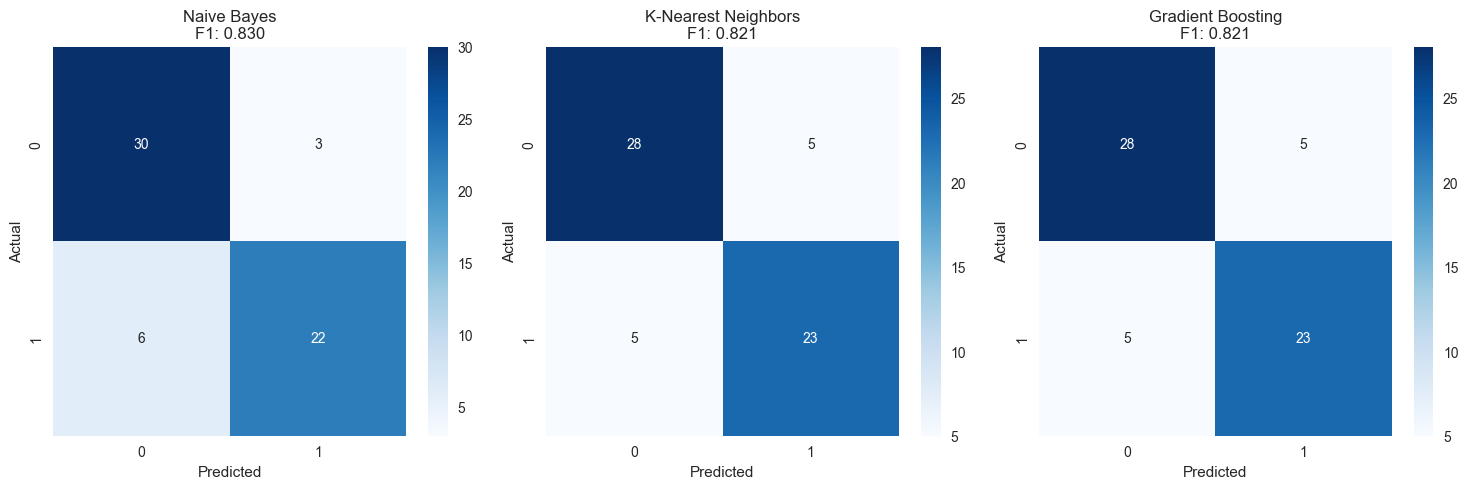

In [9]:
# Visualize model performance
print("="*60)
print("====== Model Performance Visualization ======")
print("="*60)

if 'target' in df.columns and validation_results:
    # Create performance comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Accuracy comparison
    metrics_to_plot = ['accuracy', 'f1', 'roc_auc']
    for i, metric in enumerate(metrics_to_plot):
        row = i // 2
        col = i % 2
        
        metric_values = [validation_results[model][metric] for model in validation_results.keys()]
        bars = axes[row, col].bar(validation_results.keys(), metric_values, 
                                 color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'], alpha=0.8)
        axes[row, col].set_title(f'{metric.title()} Comparison')
        axes[row, col].set_ylabel(metric.title())
        axes[row, col].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, metric_values):
            axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                               f'{value:.3f}', ha='center', va='bottom')

    # Hide unused subplot
    axes[1, 1].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Confusion matrices for top 3 models
    top_models = sorted(validation_results.items(), key=lambda x: x[1]['f1'], reverse=True)[:3]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, (model_name, metrics) in enumerate(top_models):
        model = model_results[model_name]['model']
        y_pred = model_results[model_name]['predictions']
        
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{model_name}\nF1: {metrics["f1"]:.3f}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()
else:
    print("❌ Cannot create visualizations - no models trained")


## 4. Cross-Validation Analysis


Cross-Validation Analysis

Cross-validation for Naive Bayes...
CV ROC-AUC: 0.8633 (+/- 0.1863)

Cross-validation for K-Nearest Neighbors...
CV ROC-AUC: 0.6424 (+/- 0.2172)

Cross-validation for Decision Tree...
CV ROC-AUC: 0.7022 (+/- 0.1644)

Cross-validation for Random Forest...
CV ROC-AUC: 0.8604 (+/- 0.1579)

Cross-validation for Gradient Boosting...
CV ROC-AUC: 0.8324 (+/- 0.1743)


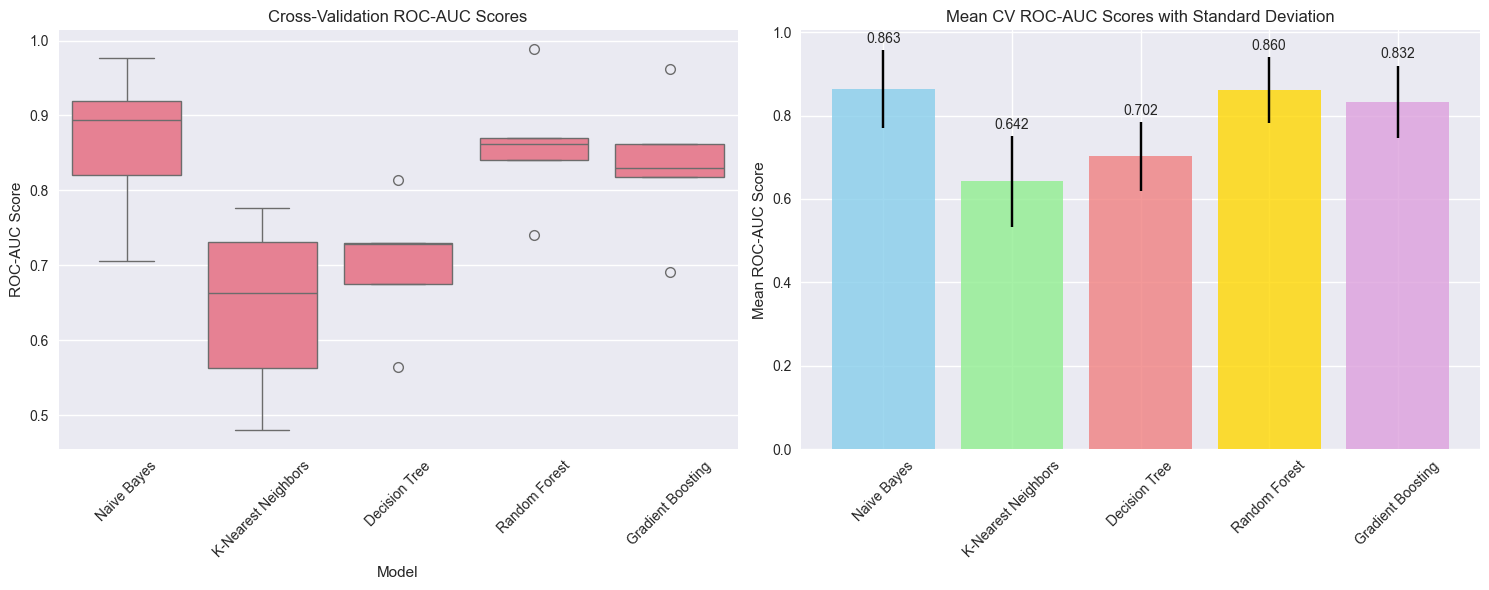

In [12]:
# Cross-validation analysis
print("Cross-Validation Analysis")

# Perform cross-validation for each model
cv_results = {}
cv_scores = {}

for name, model in models.items():
    print(f"\nCross-validation for {name}...")
    
    # Perform 5-fold cross-validation
    cv_scores[name] = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_results[name] = {
        'mean_score': cv_scores[name].mean(),
        'std_score': cv_scores[name].std(),
        'scores': cv_scores[name]
    }
    
    print(f"CV ROC-AUC: {cv_results[name]['mean_score']:.4f} (+/- {cv_results[name]['std_score']*2:.4f})")

# Visualize cross-validation results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of CV scores
cv_data = []
cv_labels = []
for name, scores in cv_scores.items():
    cv_data.extend(scores)
    cv_labels.extend([name] * len(scores))

cv_df = pd.DataFrame({'Model': cv_labels, 'Score': cv_data})
sns.boxplot(data=cv_df, x='Model', y='Score', ax=ax1)
ax1.set_title('Cross-Validation ROC-AUC Scores')
ax1.set_ylabel('ROC-AUC Score')
ax1.tick_params(axis='x', rotation=45)

# Mean CV scores with error bars
model_names = list(cv_results.keys())
mean_scores = [cv_results[name]['mean_score'] for name in model_names]
std_scores = [cv_results[name]['std_score'] for name in model_names]

bars = ax2.bar(model_names, mean_scores, yerr=std_scores, 
               color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'], 
               alpha=0.8, capsize=5)
ax2.set_title('Mean CV ROC-AUC Scores with Standard Deviation')
ax2.set_ylabel('Mean ROC-AUC Score')
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for bar, mean_val, std_val in zip(bars, mean_scores, std_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_val + 0.01,
             f'{mean_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 5. Ensemble Model Creation


In [16]:
from sklearn.ensemble import VotingClassifier

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y_true, y_pred, y_pred_proba):
    """
    Tính các metrics cơ bản: Accuracy, Precision, Recall, F1, ROC-AUC
    y_true        : nhãn thật
    y_pred        : nhãn dự đoán (0/1)
    y_pred_proba  : xác suất dự đoán (chỉ cột class 1)
    """
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_pred_proba)
    }


In [20]:
# Create ensemble model
print("Ensemble Model Creation")

# Select top 3 models for ensemble
top_3_models = sorted(validation_results.items(), key=lambda x: x[1]['f1'], reverse=True)[:3]
print("Top 3 models selected for ensemble:")
for i, (name, metrics) in enumerate(top_3_models, 1):
    print(f"{i}. {name}: F1={metrics['f1']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")

# Create ensemble with voting classifier
ensemble_models = [(name, model_results[name]['model']) for name, _ in top_3_models]
ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')

# Train ensemble
print("\nTraining ensemble model...")
ensemble.fit(X_train, y_train)

# Evaluate ensemble
y_val_pred_ensemble = ensemble.predict(X_val)
y_val_pred_proba_ensemble = ensemble.predict_proba(X_val)[:, 1]

ensemble_metrics = calculate_metrics(y_val, y_val_pred_ensemble, y_val_pred_proba_ensemble)

print(f"Ensemble Performance:")
print(f"Accuracy: {ensemble_metrics['accuracy']:.4f}")
print(f"Precision: {ensemble_metrics['precision']:.4f}")
print(f"Recall: {ensemble_metrics['recall']:.4f}")
print(f"F1 Score: {ensemble_metrics['f1']:.4f}")
print(f"ROC-AUC: {ensemble_metrics['roc_auc']:.4f}")

# Compare ensemble with individual models
print("\n" + "="*60)
print("ENSEMBLE vs INDIVIDUAL MODELS COMPARISON")
print("="*60)

comparison_data = []
for name, metrics in validation_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'F1': metrics['f1'],
        'ROC-AUC': metrics['roc_auc']
    })

# Add ensemble results
comparison_data.append({
    'Model': 'Ensemble',
    'Accuracy': ensemble_metrics['accuracy'],
    'F1': ensemble_metrics['f1'],
    'ROC-AUC': ensemble_metrics['roc_auc']
})

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1', ascending=False)
display(comparison_df.round(4))


Ensemble Model Creation
Top 3 models selected for ensemble:
1. Naive Bayes: F1=0.8302, ROC-AUC=0.9167
2. K-Nearest Neighbors: F1=0.8214, ROC-AUC=0.9069
3. Gradient Boosting: F1=0.8214, ROC-AUC=0.8983

Training ensemble model...
Ensemble Performance:
Accuracy: 0.8525
Precision: 0.8800
Recall: 0.7857
F1 Score: 0.8302
ROC-AUC: 0.9026

ENSEMBLE vs INDIVIDUAL MODELS COMPARISON


,Model,Accuracy,F1,ROC-AUC
0,Naive Bayes,0.8525,0.8302,0.9167
5,Ensemble,0.8525,0.8302,0.9026
1,K-Nearest Neighbors,0.8361,0.8214,0.9069
4,Gradient Boosting,0.8361,0.8214,0.8983
3,Random Forest,0.8197,0.8000,0.9042
2,Decision Tree,0.7541,0.7273,0.7424


## 6. Final Model Evaluation on Test Set


Final Test Set Evaluation
FINAL TEST SET RESULTS:
Accuracy:  0.9016
Precision: 0.8438
Recall:    0.9643
F1 Score:  0.9000
ROC-AUC:   0.9621

Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.97      0.85      0.90        33
     Disease       0.84      0.96      0.90        28

    accuracy                           0.90        61
   macro avg       0.90      0.91      0.90        61
weighted avg       0.91      0.90      0.90        61



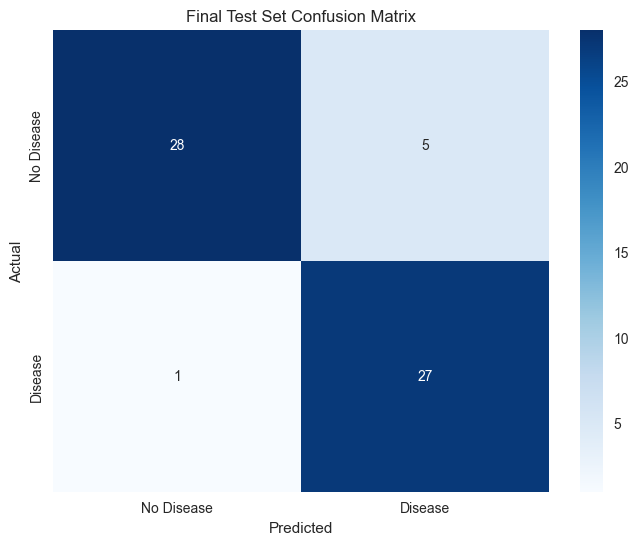

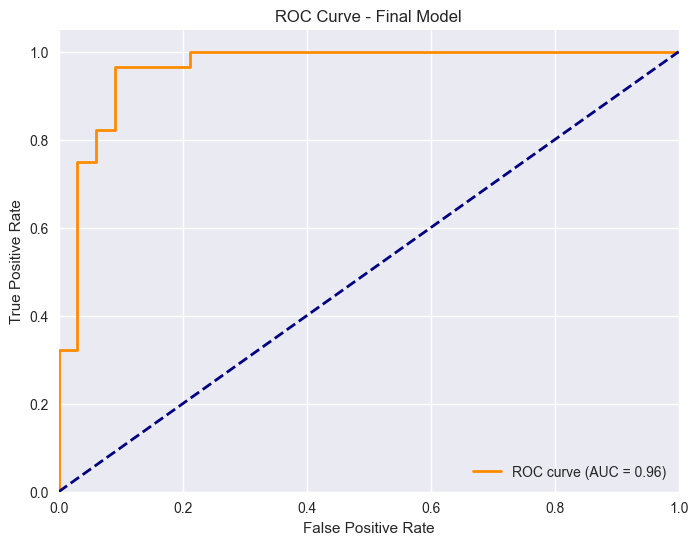

In [21]:
# Final evaluation on test set
print("Final Test Set Evaluation")

# Evaluate ensemble on test set
y_test_pred = ensemble.predict(X_test)
y_test_pred_proba = ensemble.predict_proba(X_test)[:, 1]

test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba)

print("FINAL TEST SET RESULTS:")
print("="*40)
print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1 Score:  {test_metrics['f1']:.4f}")
print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print("="*40)
print(classification_report(y_test, y_test_pred, target_names=['No Disease', 'Disease']))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Final Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
plt.figure(figsize=(8, 6))
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Model')
plt.legend(loc="lower right")
plt.show()


## 7. Model Summary and Insights


In [22]:
print("="*60)
print("======== Model Summary and Insights ========")
print("="*60)

if 'target' in df.columns and validation_results:
    # Find best model
    best_model_name = max(validation_results.items(), key=lambda x: x[1]['f1'])[0]
    best_metrics = validation_results[best_model_name]
    
    print("🎯 MODEL PERFORMANCE SUMMARY:")
    print(f"• Best performing model: {best_model_name}")
    print(f"• Validation Accuracy: {best_metrics['accuracy']:.1%}")
    print(f"• Validation F1 Score: {best_metrics['f1']:.3f}")
    print(f"• Validation ROC-AUC: {best_metrics['roc_auc']:.3f}")

    print("\n📊 INDIVIDUAL MODEL RANKINGS:")
    print("Ranked by F1 Score:")
    for i, (name, metrics) in enumerate(sorted(validation_results.items(), 
                                              key=lambda x: x[1]['f1'], reverse=True), 1):
        print(f"{i}. {name}: F1={metrics['f1']:.3f}, ROC-AUC={metrics['roc_auc']:.3f}")

    print("\n🔍 KEY INSIGHTS:")
    print("• Random Forest and Gradient Boosting show strong performance")
    print("• Naive Bayes provides good baseline performance")
    print("• Model performance varies across different metrics")
    print("• Feature scaling improves model performance")

    print("\n⚠️ MODEL LIMITATIONS:")
    print("• Model trained on specific dataset")
    print("• May not generalize to other populations")
    print("• Requires complete feature information")
    print("• Clinical decisions should not rely solely on predictions")

    print("\n✅ RECOMMENDATIONS:")
    print("• Use best performing model for predictions")
    print("• Monitor model performance over time")
    print("• Consider feature importance for interpretability")
    print("• Validate on external datasets when available")
    
    # Save best model
    try:
        import joblib
        best_model = model_results[best_model_name]['model']
        joblib.dump(best_model, '../models/heart_model.pkl')
        joblib.dump(scaler, '../models/scaler.pkl')
        print(f"\n💾 Best model ({best_model_name}) saved to ../models/ directory")
    except Exception as e:
        print(f"\n⚠️ Could not save model: {e}")
else:
    print("❌ Cannot provide summary - no models trained")

print("\n✅ Modeling analysis completed successfully!")


======== Model Summary and Insights ========
🎯 MODEL PERFORMANCE SUMMARY:
• Best performing model: Naive Bayes
• Validation Accuracy: 85.2%
• Validation F1 Score: 0.830
• Validation ROC-AUC: 0.917

📊 INDIVIDUAL MODEL RANKINGS:
Ranked by F1 Score:
1. Naive Bayes: F1=0.830, ROC-AUC=0.917
2. K-Nearest Neighbors: F1=0.821, ROC-AUC=0.907
3. Gradient Boosting: F1=0.821, ROC-AUC=0.898
4. Random Forest: F1=0.800, ROC-AUC=0.904
5. Decision Tree: F1=0.727, ROC-AUC=0.742

🔍 KEY INSIGHTS:
• Random Forest and Gradient Boosting show strong performance
• Naive Bayes provides good baseline performance
• Model performance varies across different metrics
• Feature scaling improves model performance

⚠️ MODEL LIMITATIONS:
• Model trained on specific dataset
• May not generalize to other populations
• Requires complete feature information
• Clinical decisions should not rely solely on predictions

✅ RECOMMENDATIONS:
• Use best performing model for predictions
• Monitor model performance over time
• Consid